In [1]:
# the aim is to end up with train, test, evaluate
import sys
sys.path.append("/Users/david/Documents/code/fhmm/v1")

In [3]:
import src.ads_davidjames9610.ads as ads
import src.ads_davidjames9610.useful as useful
import numpy as np
import os
import os.path
from pathlib import Path
import matplotlib.pyplot as plt
from importlib import reload
import importlib
import src.classifiers_davidjames9610.test_a.config as base_config
reload(base_config)
config = importlib.import_module(base_config.config_location)
reload(config)
print(config.basedir)
import src.misc_davidjames9610.fe_methods as fe
import src.misc_davidjames9610.proc_methods as pm

/Users/david/Documents/code/fhmm/v1/src/classifiers_davidjames9610/test_a/ivector_speech_data


In [4]:
import src.misc_davidjames9610.utils as utils
sls = utils.load_pickle(config.samples_labels)

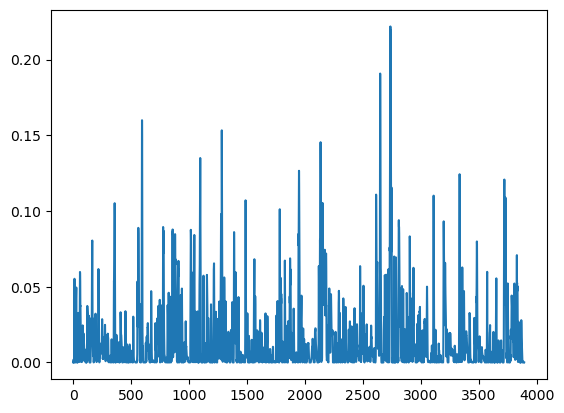

0.01500180948200443


In [6]:
# going to have to do fe after cross-validation split
import src.misc_davidjames9610.cross_validation as cv
from src.misc_davidjames9610.cross_validation import *
import importlib
importlib.reload(cv)
import b_samples_to_features
reload(b_samples_to_features)
import src.misc_davidjames9610.noisey as noisey
reload(noisey)
import random

# define config things
n_folds = 2
cv_output = cv.split_data_for_cross_validation(sls['samples'], sls['labels'], n_folds) # , test_ratio=0.8) # could update test ratio to
signal_average_power = b_samples_to_features.get_average_power_for_samples(cv_output)
signal_average_power_v2 = np.square(np.linalg.norm(np.concatenate(cv_output['train_data'][0][:50]), ord=2)) / len(np.concatenate(cv_output['train_data'][0][:50]))
signal_average_power_db = 10 * np.log10(signal_average_power)
max_sample_length = np.max([len(sample) for sample in sls['samples']])
print(signal_average_power)

In [7]:
# from src.misc_davidjames9610.noisey import get_noise_avg_watts
# import importlib
# importlib.reload(fe)
#
#
# class ProcessingBase:
#     def __init__(self, fe_method):
#         self.fe_method = fe_method
#     def __str__(self):
#         return self.fe_method.__str__() + '_None_None'
#     def pre_process(self, sample):
#         return self.fe_method(sample)
#     def post_process(self, sample):
#         return self.fe_method(sample)
#     def get_noise_feature(self):
#         pass
#
# class ProcessingGaussNoise:
#     def __init__(self, fe_method, snr, signal_power, sample_len):
#         self.fe_method = fe_method
#         self.snr = snr
#         self.signal_power = signal_power
#         self.noise_sample = noisey.get_noise_for_sample(sample_len, self.signal_power, self.snr, self.snr, self.snr)
#
#     def __str__(self):
#         return self.fe_method.__str__() + '_GaussNoise_SNR' + str(self.snr)
#     def pre_process(self, sample):
#         return self.fe_method(sample)
#     def post_process(self, sample):
#         sample = self.noise_sample[:len(sample)] + sample
#         return self.fe_method(sample)
#     def get_noise_feature(self):
#         return self.fe_method(self.noise_sample)
#
# class ProcessingRealNoise:
#     def __init__(self, fe_method, snr, signal_power, sample_len, noise_key):
#
#         self.fe_method = fe_method
#         self.snr = snr
#         self.signal_power = signal_power
#         self.noise_key = noise_key
#
#         self.noise_sample = b_samples_to_features.get_real_noise_sample(
#             noise_key=base_config.noise_sound_lib[noise_key], target_snr_db=snr, signal_db=signal_power, sample_len=sample_len, sr=config.sr)
#
#         print('completed ProcessingRealNoise')
#
#     def __str__(self):
#         return self.fe_method.__str__() + '_RealNoise_' + self.noise_key + '_SNR' + str(self.snr)
#
#     def pre_process(self, sample):
#         return self.fe_method(sample)
#     def post_process(self, sample):
#         sample = self.noise_sample[:len(sample)] + sample
#         return self.fe_method(sample)
#     def get_noise_feature(self):
#         return self.fe_method(self.noise_sample)
#
# class ProcessingGaussNoiseReverb:
#     # todo finish this somehow
#     def __init__(self, fe_method, snr, signal_power, sample_len):
#         self.snr = snr
#         self.signal_power = signal_power
#         self.fe_method = fe_method
#     def __str__(self):
#         return self.fe_method.__str__() + '_GaussNoise_SNR' + str(self.snr) + '_Reverb'
#     def pre_process(self, sample):
#         return self.fe_method(sample)
#     def post_process(self, sample):
#         # todo update so Gauss Noise Reverb works
#         return self.fe_method(sample)
#     def get_noise_feature(self):
#         # update
#         return []


In [8]:
importlib.reload(fe)

num_ceps = 13
nfft = 128

proc_methods = [
    b_samples_to_features.ProcessingBase(
        fe_method=fe.FeatureExtractorLogPower(nfft=nfft)),
    b_samples_to_features.ProcessingBase(
        fe_method=fe.FeatureExtractorMfcc(nfft=nfft, num_ceps=num_ceps, fs=config.sr),
    ),
]

snrs_gauss = [40,20,10,0,-10]
snrs_real = [40,20,10,0,-10]

proc_methods.extend([b_samples_to_features.ProcessingGaussNoise(
        fe_method=fe.FeatureExtractorLogPower(nfft=nfft),
        snr=snr,
        signal_power=signal_average_power_db,
        sample_len=max_sample_length) for snr in snrs_gauss])

proc_methods.extend([b_samples_to_features.ProcessingRealNoise(
        fe_method=fe.FeatureExtractorLogPower(nfft=nfft),
        snr=snr,
        signal_power=signal_average_power_db,
        sample_len=max_sample_length,
        noise_key='UNDER_WATER_DRONE'
        ) for snr in snrs_real])

proc_methods.extend([b_samples_to_features.ProcessingGaussNoise(
        fe_method=fe.FeatureExtractorMfcc(nfft=nfft, num_ceps=num_ceps, fs=config.sr),
        snr=snr,
        signal_power=signal_average_power_db,
        sample_len=max_sample_length) for snr in snrs_gauss])

proc_methods.extend([b_samples_to_features.ProcessingRealNoise(
        fe_method=fe.FeatureExtractorMfcc(nfft=nfft, num_ceps=num_ceps, fs=config.sr),
        snr=snr,
        signal_power=signal_average_power_db,
        sample_len=max_sample_length,
        noise_key='UNDER_WATER_DRONE'
        ) for snr in snrs_real])


completed ProcessingRealNoise
completed ProcessingRealNoise
completed ProcessingRealNoise
completed ProcessingRealNoise
completed ProcessingRealNoise
completed ProcessingRealNoise
completed ProcessingRealNoise
completed ProcessingRealNoise
completed ProcessingRealNoise
completed ProcessingRealNoise


In [9]:
for proc_method in proc_methods:
    print("'" + proc_method.__str__() + "',")
    
print('done!')


'lp_None_None',
'mfcc_None_None',
'lp_GaussNoise_SNR40',
'lp_GaussNoise_SNR20',
'lp_GaussNoise_SNR10',
'lp_GaussNoise_SNR0',
'lp_GaussNoise_SNR-10',
'lp_RealNoise_UNDER_WATER_DRONE_SNR40',
'lp_RealNoise_UNDER_WATER_DRONE_SNR20',
'lp_RealNoise_UNDER_WATER_DRONE_SNR10',
'lp_RealNoise_UNDER_WATER_DRONE_SNR0',
'lp_RealNoise_UNDER_WATER_DRONE_SNR-10',
'mfcc_GaussNoise_SNR40',
'mfcc_GaussNoise_SNR20',
'mfcc_GaussNoise_SNR10',
'mfcc_GaussNoise_SNR0',
'mfcc_GaussNoise_SNR-10',
'mfcc_RealNoise_UNDER_WATER_DRONE_SNR40',
'mfcc_RealNoise_UNDER_WATER_DRONE_SNR20',
'mfcc_RealNoise_UNDER_WATER_DRONE_SNR10',
'mfcc_RealNoise_UNDER_WATER_DRONE_SNR0',
'mfcc_RealNoise_UNDER_WATER_DRONE_SNR-10',
done!


In [10]:
noise_samp = proc_methods[5].noise_sample
10 * np.log10(np.mean(noise_samp ** 2))

-18.19642016388145

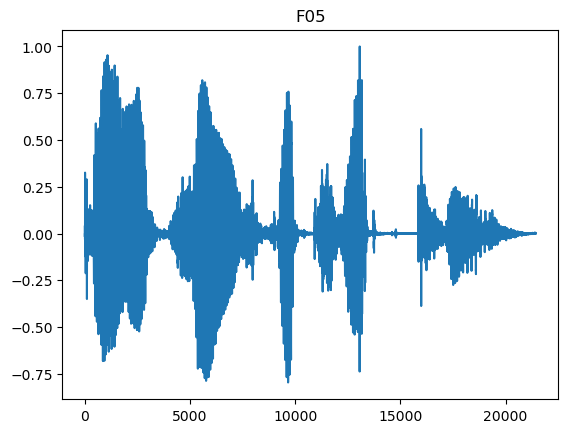

----
lp_RealNoise_UNDER_WATER_DRONE_SNR40
average sample_power:  -18.238563542340405
snr w/ average:        39.999999995257255
sample_power:          -15.689952373504639
noise_power:           -58.238563537597656
snr                    42.54861116409302


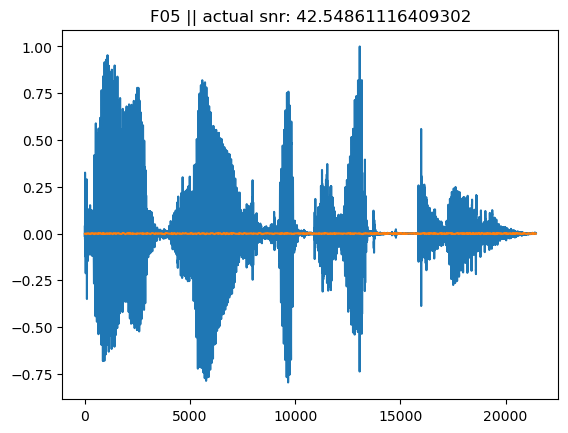

----
----
lp_RealNoise_UNDER_WATER_DRONE_SNR20
average sample_power:  -18.238563542340405
snr w/ average:        19.99999999525725
sample_power:          -15.689952373504639
noise_power:           -38.238563537597656
snr                    22.548611164093018


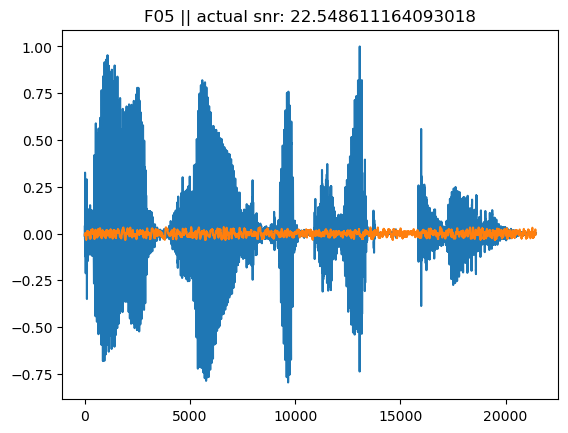

----
----
lp_RealNoise_UNDER_WATER_DRONE_SNR10
average sample_power:  -18.238563542340405
snr w/ average:        9.999999995257252
sample_power:          -15.689952373504639
noise_power:           -28.238563537597656
snr                    12.548611164093018


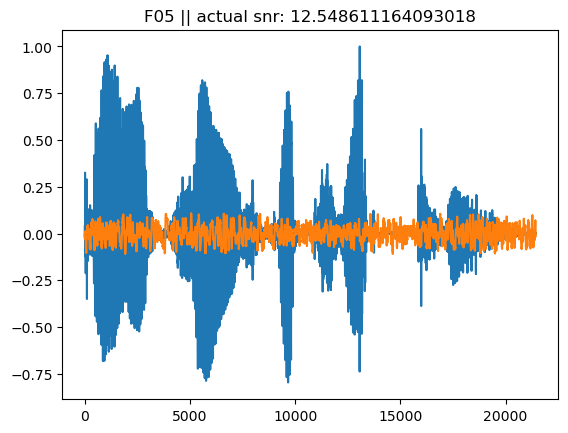

----
----
lp_RealNoise_UNDER_WATER_DRONE_SNR0
average sample_power:  -18.238563542340405
snr w/ average:        -4.742748416219911e-09
sample_power:          -15.689952373504639
noise_power:           -18.238563537597656
snr                    2.5486111640930176


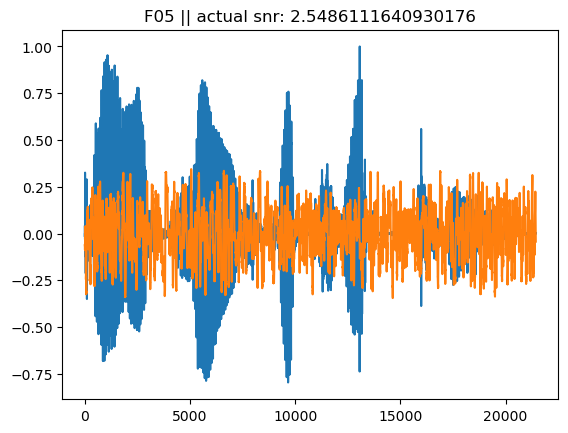

----
----
lp_RealNoise_UNDER_WATER_DRONE_SNR-10
average sample_power:  -18.238563542340405
snr w/ average:        -10.000000600789196
sample_power:          -15.689952373504639
noise_power:           -8.238562941551208
snr                    -7.45138943195343


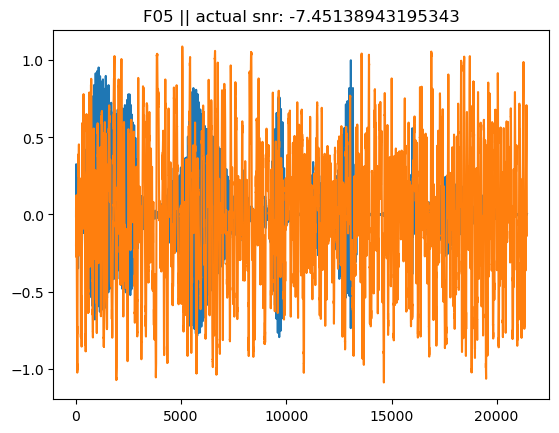

----


In [11]:
proc_methods_to_inspect = [
# 'lp_GaussNoise_SNR60',
# 'lp_GaussNoise_SNR40',
# 'lp_GaussNoise_SNR20',
# 'lp_GaussNoise_SNR10',
'lp_RealNoise_UNDER_WATER_DRONE_SNR40',
'lp_RealNoise_UNDER_WATER_DRONE_SNR20',
'lp_RealNoise_UNDER_WATER_DRONE_SNR10',
'lp_RealNoise_UNDER_WATER_DRONE_SNR0',
'lp_RealNoise_UNDER_WATER_DRONE_SNR-10',
]

i = 50

sample_to_inspect = cv_output['train_data'][0][i]
label = sls['num_to_label'][cv_output['train_label'][0][i]]

plt.plot(sample_to_inspect)
plt.title(label)
plt.show()

for proc_method in proc_methods:
    if proc_method.__str__() in proc_methods_to_inspect and proc_method.__str__().__contains__('Noise'):


        sample_power = (np.mean(sample_to_inspect ** 2))
        sample_power_db = 10 * np.log10(sample_power)

        noise_samp = proc_method.noise_sample

        noise_power = np.mean(noise_samp ** 2)
        noise_power_db = 10 * np.log10(np.mean(noise_samp ** 2))

        snr = sample_power_db - noise_power_db

        print('----')
        print(proc_method.__str__())
        print('average sample_power: ', signal_average_power_db)
        print('snr w/ average:       ', signal_average_power_db - noise_power_db )
        print('sample_power:         ', sample_power_db)
        print('noise_power:          ', noise_power_db)
        print('snr                   ', sample_power_db - noise_power_db )

        plt.plot(sample_to_inspect)
        plt.plot(proc_method.noise_sample[:len(sample_to_inspect)])


        plt.title(label + ' || actual snr: ' + str(snr))
        plt.show()

        print('----')



In [12]:
reload(fe)

features = {
}

import b_samples_to_features
reload(b_samples_to_features)

for proc_method in proc_methods:

    fe_name = proc_method.__str__()
    features[fe_name] = {}
    print('processing for: ', fe_name)
    n_folds = len(cv_output['train_data'])

    # train
    train_features = []
    train_labels = []
    for i in range(n_folds):
        curr_features = []
        curr_labels = []

        for sample_i in range(len(cv_output['train_data'][i])):
            sample = cv_output['train_data'][i][sample_i]
            curr_label = cv_output['train_label'][i][sample_i]
            try: # 65
                curr_feature = proc_method.pre_process(sample)
                if curr_feature.shape[0] > 1:
                    curr_features.append(curr_feature)
                    curr_labels.append(curr_label)
                else: print('sample to short at index', sample_i)
            except:
                print('sample to short at index', sample_i)

        train_features.append(curr_features)
        train_labels.append(curr_labels)

    features[fe_name]['train_features'] = train_features
    features[fe_name]['train_label'] = train_labels

    # val
    val_features = []
    val_labels = []
    val_noise = []
    for i in range(n_folds):
        curr_features = []
        curr_labels = []
        curr_noise_features = []

        for sample_i in range(len(cv_output['val_data'][i])):
            sample = cv_output['val_data'][i][sample_i]
            curr_label = cv_output['val_label'][i][sample_i]
            try:
                curr_feature = proc_method.post_process(sample)
                if curr_feature.shape[0] > 1:
                    curr_features.append(curr_feature)
                    curr_labels.append(curr_label)
                else: print('sample to short at index', sample_i)
            except:
                print('sample to short at index', sample_i)

        curr_noise_features.append(proc_method.get_noise_feature())

        val_features.append(curr_features)
        val_labels.append(curr_labels)
        val_noise.append(curr_noise_features)

    features[fe_name]['val_features'] = val_features
    features[fe_name]['val_label'] = val_labels
    features[fe_name]['noise_features'] = val_noise

print('done!')


processing for:  lp_None_None
processing for:  mfcc_None_None
processing for:  lp_GaussNoise_SNR40
processing for:  lp_GaussNoise_SNR20
processing for:  lp_GaussNoise_SNR10
processing for:  lp_GaussNoise_SNR0
processing for:  lp_GaussNoise_SNR-10
processing for:  lp_RealNoise_UNDER_WATER_DRONE_SNR40
processing for:  lp_RealNoise_UNDER_WATER_DRONE_SNR20
processing for:  lp_RealNoise_UNDER_WATER_DRONE_SNR10
processing for:  lp_RealNoise_UNDER_WATER_DRONE_SNR0
processing for:  lp_RealNoise_UNDER_WATER_DRONE_SNR-10
processing for:  mfcc_GaussNoise_SNR40
processing for:  mfcc_GaussNoise_SNR20
processing for:  mfcc_GaussNoise_SNR10
processing for:  mfcc_GaussNoise_SNR0
processing for:  mfcc_GaussNoise_SNR-10
processing for:  mfcc_RealNoise_UNDER_WATER_DRONE_SNR40
processing for:  mfcc_RealNoise_UNDER_WATER_DRONE_SNR20
processing for:  mfcc_RealNoise_UNDER_WATER_DRONE_SNR10
processing for:  mfcc_RealNoise_UNDER_WATER_DRONE_SNR0
processing for:  mfcc_RealNoise_UNDER_WATER_DRONE_SNR-10
done!


In [13]:
import src.misc_davidjames9610.utils as utils
reload(utils)
import pickle
utils.dict_to_folder_pickles(config.basedir + '/features', features)

Directory '/Users/david/Documents/code/fhmm/v1/src/classifiers_davidjames9610/test_a/ivector_speech_data/features' already exists, removing old files:  False
saving / updating  lp_None_None
saving / updating  mfcc_None_None
saving / updating  lp_GaussNoise_SNR40
saving / updating  lp_GaussNoise_SNR20
saving / updating  lp_GaussNoise_SNR10
saving / updating  lp_GaussNoise_SNR0
saving / updating  lp_GaussNoise_SNR-10
saving / updating  lp_RealNoise_UNDER_WATER_DRONE_SNR40
saving / updating  lp_RealNoise_UNDER_WATER_DRONE_SNR20
saving / updating  lp_RealNoise_UNDER_WATER_DRONE_SNR10
saving / updating  lp_RealNoise_UNDER_WATER_DRONE_SNR0
saving / updating  lp_RealNoise_UNDER_WATER_DRONE_SNR-10
saving / updating  mfcc_GaussNoise_SNR40
saving / updating  mfcc_GaussNoise_SNR20
saving / updating  mfcc_GaussNoise_SNR10
saving / updating  mfcc_GaussNoise_SNR0
saving / updating  mfcc_GaussNoise_SNR-10
saving / updating  mfcc_RealNoise_UNDER_WATER_DRONE_SNR40
saving / updating  mfcc_RealNoise_UNDE

In [14]:
from collections import Counter

def feature_report(some_features):
    feats = some_features['train_features'][0]
    labels = some_features['train_label'][0]
    counter = Counter(labels)
    print(counter)

    for label in counter:
            mask = (np.array(labels) == label)
            mask = mask.tolist()
            speaker_features = [array for array, flag in zip(curr_features, mask) if flag]
            lengths = [len(speaker_feature) for speaker_feature in speaker_features]
            print(sls['num_to_label'][label], np.round(np.mean(lengths) * 10) / 10)


feature_report(features['mfcc_None_None'])

# Counter({1: 24, 5: 23, 0: 19, 3: 16, 2: 14, 4: 8})
# 5 16.869565217391305
# 3 56.75
# 1 29.166666666666668
# 0 15.0
# 2 8.0
# 4 36.25

Counter({2: 112, 4: 102, 8: 101, 1: 96, 0: 94, 3: 93, 6: 91, 5: 88, 9: 83, 7: 83})
M05 266.4
F08 325.3
M01 259.9
M09 277.0
F06 327.8
F05 300.6
M08 301.0
F07 290.5
F03 322.3
M07 251.2


In [25]:
# reload(utils)
# my_dict = utils.folder_pickles_to_dict(config.basedir + '/features', 'lp')